In [37]:
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import seaborn as sns
import json

In [2]:
with open('takehome_users.csv', 'r') as f:
    users = pd.read_csv(f)
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


In [3]:
with open('takehome_user_engagement.csv', 'r') as f:
    userLogins = pd.read_csv(f)
userLogins

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [4]:
userLogins.visited.unique()

array([1], dtype=int64)

In [5]:
userLogins.drop(columns='visited', inplace=True)

In [6]:
userLogins.dtypes

time_stamp    object
user_id        int64
dtype: object

In [7]:
userLogins['date'] = pd.to_datetime(pd.to_datetime(userLogins.time_stamp).dt.date)
userLogins.drop(columns='time_stamp', inplace=True)
userLogins.drop_duplicates(inplace=True)

In [8]:
loginCts = userLogins.groupby('user_id').count().reset_index().rename(columns={'date':'logins'})
loginCts['met_min_logins'] = loginCts.logins >= 3
potentialAdopted = loginCts.user_id[loginCts.met_min_logins == True]
userLogins = userLogins[userLogins.user_id.isin(potentialAdopted)]
userLogins

,user_id,date
1,2,2013-11-15
2,2,2013-11-29
3,2,2013-12-09
4,2,2013-12-25
5,2,2013-12-31
...,...,...
207905,11991,2014-04-20
207906,11991,2014-04-25
207907,11991,2014-04-28
207908,11991,2014-05-17


In [9]:
def userAdopted(user):
    i=0
    while (i+2) < len(user.index):
        if (user.date.iloc[i+1] - user.date.iloc[i]) <= pd.Timedelta(days=7) and \
        (user.date.iloc[i+2] - user.date.iloc[i]) <= pd.Timedelta(days=7):
            return True
        else:
            i+=1
    return False

In [10]:
adoptedUsers = userLogins.groupby('user_id').filter(lambda x: userAdopted(x) == True).user_id.unique()
users['adopted'] = users.object_id.isin(adoptedUsers)
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,False
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,False
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,False
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,False


In [11]:
users.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
adopted                          bool
dtype: object

In [12]:
userData = users.drop(columns=['name', 'email'])
userData.creation_time = pd.to_datetime(userData.creation_time)
userData = userData.join(pd.get_dummies(userData.creation_source)).drop(columns='creation_source')
userData.adopted = userData.adopted.astype(int)
userData

,object_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,1.398139e+09,1,0,11,10803.0,0,1,0,0,0,0
1,2,2013-11-15 03:45:04,1.396238e+09,0,0,1,316.0,1,0,1,0,0,0
2,3,2013-03-19 23:14:52,1.363735e+09,0,0,94,1525.0,0,0,1,0,0,0
3,4,2013-05-21 08:09:28,1.369210e+09,0,0,1,5151.0,0,1,0,0,0,0
4,5,2013-01-17 10:14:20,1.358850e+09,0,0,193,5240.0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,1.378448e+09,0,0,89,8263.0,0,0,1,0,0,0
11996,11997,2013-01-10 18:28:37,1.358275e+09,0,0,200,NaN,0,0,0,0,0,1
11997,11998,2014-04-27 12:45:16,1.398603e+09,1,1,83,8074.0,0,1,0,0,0,0
11998,11999,2012-05-31 11:55:59,1.338638e+09,0,0,6,NaN,0,0,0,1,0,0


In [13]:
userData.isna().sum()

object_id                        0
creation_time                    0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted                          0
GUEST_INVITE                     0
ORG_INVITE                       0
PERSONAL_PROJECTS                0
SIGNUP                           0
SIGNUP_GOOGLE_AUTH               0
dtype: int64

In [14]:
#if this statement is zero, it is likely that "last_session_creation_time" being NA indicates no recent session
userData[userData.last_session_creation_time.isna()].adopted.sum()

0

In [15]:
#if this statement is zero, it is likely that "invited_by_user_id" being NA indicates no invite
userData[userData.invited_by_user_id.isna()].loc[:,['GUEST_INVITE','ORG_INVITE']].sum().sum()

0

In [16]:
userData.fillna(0, inplace=True)
#if this statement is zero, we can safely convert invited_by_user_id to an int
userData.invited_by_user_id.map(lambda x: not x.is_integer()).sum()

0

In [17]:
userData.invited_by_user_id = userData.invited_by_user_id.astype(int)
userData.dtypes

object_id                              int64
creation_time                 datetime64[ns]
last_session_creation_time           float64
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                     int32
adopted                                int32
GUEST_INVITE                           uint8
ORG_INVITE                             uint8
PERSONAL_PROJECTS                      uint8
SIGNUP                                 uint8
SIGNUP_GOOGLE_AUTH                     uint8
dtype: object

In [18]:
#make creation_time unix for processing
userData.creation_time = (userData.creation_time - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
userData

,object_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,1398138810,1.398139e+09,1,0,11,10803,0,1,0,0,0,0
1,2,1384487104,1.396238e+09,0,0,1,316,1,0,1,0,0,0
2,3,1363734892,1.363735e+09,0,0,94,1525,0,0,1,0,0,0
3,4,1369123768,1.369210e+09,0,0,1,5151,0,1,0,0,0,0
4,5,1358417660,1.358850e+09,0,0,193,5240,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,1378448055,1.378448e+09,0,0,89,8263,0,0,1,0,0,0
11996,11997,1357842517,1.358275e+09,0,0,200,0,0,0,0,0,0,1
11997,11998,1398602716,1.398603e+09,1,1,83,8074,0,1,0,0,0,0
11998,11999,1338465359,1.338638e+09,0,0,6,0,0,0,0,1,0,0


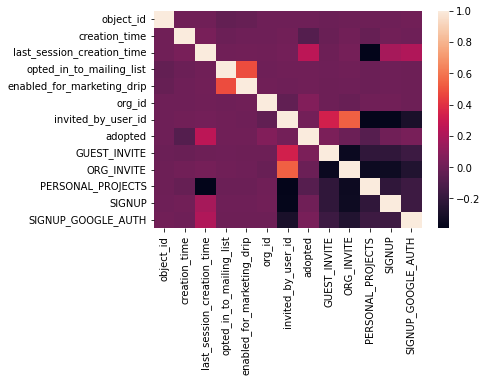

In [19]:
_=sns.heatmap(userData.corr()) 

In [20]:
#There are no strong or unexpected correlations so we can proceed
X = userData.drop(columns=['object_id','adopted'])
y = userData.adopted
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('selector', SelectKBest(score_func=chi2, k='all'))
])
pipe.fit(X,y)
pd.DataFrame({'Feature':pipe.named_steps.scaler.feature_names_in_,'P':pipe.named_steps.selector.pvalues_}).sort_values('P')

,Feature,P
1,last_session_creation_time,1.381264e-44
8,PERSONAL_PROJECTS,5.091785e-14
6,GUEST_INVITE,1.105368e-05
4,org_id,1.787134e-04
0,creation_time,1.895295e-04
10,SIGNUP_GOOGLE_AUTH,1.918944e-04
5,invited_by_user_id,1.323411e-01
9,SIGNUP,3.744588e-01
2,opted_in_to_mailing_list,4.016373e-01
3,enabled_for_marketing_drip,5.062787e-01


Adopted users are more likely to have used the system more recently, so last_session_creation_time doesn't predict adoption, but the other way around. Probably best to drop it.

In [52]:
X = userData.drop(columns=['object_id','adopted', 'last_session_creation_time'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=191)
model = Pipeline([
    ('scaler', MinMaxScaler()),
    ('GBClassifier', GradientBoostingClassifier())
])
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, output_dict=False))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92      3405
           1       0.14      0.00      0.00       555

    accuracy                           0.86      3960
   macro avg       0.50      0.50      0.46      3960
weighted avg       0.76      0.86      0.79      3960



In [51]:
#this will do for a rudimentary model for predicting feature importance
#but there simply isn't enough data get a solid result without resampling
pd.DataFrame({'Feature':model.named_steps.scaler.feature_names_in_,'Importance':model.named_steps.GBClassifier.feature_importances_}).sort_values('Importance', ascending=False)

,Feature,Importance
0,creation_time,0.524754
3,org_id,0.229253
7,PERSONAL_PROJECTS,0.092067
4,invited_by_user_id,0.074477
5,GUEST_INVITE,0.027837
9,SIGNUP_GOOGLE_AUTH,0.023548
6,ORG_INVITE,0.010319
2,enabled_for_marketing_drip,0.007534
1,opted_in_to_mailing_list,0.006716
8,SIGNUP,0.003494


In [61]:
adoptedUserCreationTime = userData[userData.adopted==1].creation_time.mean()
avgCreationTime = userData.creation_time.mean()
#If the following statement is false, older users are more likely to have adopted
adoptedUserCreationTime > avgCreationTime

False

In [64]:
adoptedUserPersProjAvg = userData[userData.adopted==1].PERSONAL_PROJECTS.mean()
persProjAvg = userData.PERSONAL_PROJECTS.mean()
#If the following statement is false, people who try the platform for personal projects are less likely to adopt
adoptedUserPersProjAvg > persProjAvg

False

### Conclusion:

Users who created their accounts longer ago were more likely to adopt. Those who try the platform out for personal projects are less likely to adopt. Certain organizations and users that invite people may also determine the invitees decision to adopt the platform.

Additional data would be very helpful. Perhaps some form of usage statistics beyond reason for use or session creation times.